In [1]:
#This is the 3 fold newton frame covariance for simulation data.

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numba import njit
import os

os.chdir(r'C:\Users\zhiha\Desktop\computation\OCS\CEI_simulation\3_fold_cov')

In [19]:
# load the data and transfer the data to pandas dataframe  

A_ion_path = 'OCS_C+_3_fold.npy' # Reference ion
B_ion_path = 'OCS_O2+_3_fold.npy'
C_ion_path = 'OCS_S3+_3_fold.npy'

ion_A = 'C+'
ion_B = 'O++'
ion_C = 'S+++'


# define some parameters, same as the code in experiment data
pixels = 200
hlf_pxl = int(pixels/2)
bin_size = 5 # Change this to change image size
n_SiSjSk = 50 # Change this to change processing time, needs to be higher for 3-fold than 2-fold. 50 is good amount. 
p_sum_min, p_sum_max = 0, 15 # This controls the minimum and maximum momentum sum limit on the three fragments (in a.u.).

columns = ["shot", "p_x", "p_y", "p_z", "p_xy", "p_tot", "mq"]

data_A = np.load(A_ion_path)
data_B = np.load(B_ion_path)
data_C = np.load(C_ion_path)

df_A = pd.DataFrame(data_A, columns=columns)
df_B = pd.DataFrame(data_B, columns=columns)
df_C = pd.DataFrame(data_C, columns=columns)


# Display the first few rows
print(df_A.head())



   shot        p_x        p_y        p_z       p_xy      p_tot    mq
0   1.0 -45.819563 -18.037630 -80.286199  49.242141  94.184193  12.0
1   1.0  72.818225  15.743655   1.970686  74.500715  74.526775  12.0
2   1.0 -77.016693  47.674056  26.531654  90.578069  94.383872  12.0
3   1.0 -17.535429 -77.448877 -16.137554  79.409192  81.032342  12.0
4   1.0 -77.693658  26.428758 -51.173453  82.065728  96.713526  12.0


In [20]:
#Transfer the data to numpy array which is used for the calculation

short_array = df_A[['shot']].values
A_array = df_A[['shot','p_x', 'p_y', 'p_xy']].values
B_array = df_B[['shot','p_x', 'p_y', 'p_xy']].values
C_array = df_C[['shot','p_x', 'p_y', 'p_xy']].values

print(A_array.shape)

(119708, 4)


In [21]:
#Import functions in the 3 fold covariance calculation


def cov_3fold_2D_Newton_plot_with_conservation(A_array, B_array, C_array, shot_array, n_SiSjSk, bin_size, p_sum_min, p_sum_max, pixels):

    shot_array_A, shot_array_B, shot_array_C = A_array[:, 0], B_array[:, 0], C_array[:, 0]
    shot_array_Sijk = np.intersect1d(np.intersect1d(shot_array_A, shot_array_B), shot_array_C).astype('int64')
    shot_array_SiSjSk = np.unique(np.append(np.append(shot_array_A, shot_array_B), shot_array_C)).astype('int64')
    ratio = len(shot_array)/len(shot_array_SiSjSk)
    
    Sijk = cov_3fold_term_2D_Newton_plot_with_conservation(A_array, B_array, C_array, shot_array_Sijk, 0, 0, bin_size, p_sum_min, p_sum_max, pixels)

    SijSk_list, SikSj_list, SjkSi_list, SiSjSk_list = [], [], [], []
    for n in range(n_SiSjSk):

        shift_no_1, shift_no_2 = np.random.choice(np.arange(len(shot_array_SiSjSk)), size = 2, replace = False)
        SijSk = cov_3fold_term_2D_Newton_plot_with_conservation(A_array, B_array, C_array, shot_array_SiSjSk, 0, shift_no_1, bin_size, p_sum_min, p_sum_max, pixels)
        SijSk_list.append(SijSk)
        SikSj = cov_3fold_term_2D_Newton_plot_with_conservation(A_array, B_array, C_array, shot_array_SiSjSk, shift_no_1, 0, bin_size, p_sum_min, p_sum_max, pixels)
        SikSj_list.append(SikSj)
        SjkSi = cov_3fold_term_2D_Newton_plot_with_conservation(A_array, B_array, C_array, shot_array_SiSjSk, shift_no_1, shift_no_1, bin_size, p_sum_min, p_sum_max, pixels)
        SjkSi_list.append(SjkSi)
        SiSjSk = cov_3fold_term_2D_Newton_plot_with_conservation(A_array, B_array, C_array, shot_array_SiSjSk, shift_no_1, shift_no_2, bin_size, p_sum_min, p_sum_max, pixels)
        SiSjSk_list.append(SiSjSk)

    SijSk = sum(SijSk_list)/(n_SiSjSk*ratio)
    SikSj = sum(SikSj_list)/(n_SiSjSk*ratio)
    SjkSi = sum(SjkSi_list)/(n_SiSjSk*ratio)
    SiSjSk = sum(SiSjSk_list)/(n_SiSjSk*ratio*ratio)
    
    cov = Sijk - SijSk - SikSj - SjkSi + 2*SiSjSk 

    return(Sijk, SijSk, SikSj, SjkSi, SiSjSk, cov)

@njit()
def cov_3fold_term_2D_Newton_plot_with_conservation(A_array, B_array, C_array, shot_array, shift_no_1, shift_no_2, bin_size, p_sum_min, p_sum_max, pixels):
    
    term = np.zeros((pixels, pixels))
    hlf_pxl = int(pixels/2)
    
    A_total = A_array.shape[0]
    B_total = B_array.shape[0]
    C_total = C_array.shape[0]
    
    A_start, B_start, C_start = 0, 0, 0
    A_end, B_end, C_end = 0, 0, 0
    
    shot_array_2 = np.roll(shot_array, -shift_no_1)
    shot_array_3 = np.roll(shot_array, -shift_no_2)
    
    prev_shot_2 = 0
    prev_shot_3 = 0

    for shot_1, shot_2, shot_3 in zip(shot_array, shot_array_2, shot_array_3):
    
        A_in_shot, B_in_shot, C_in_shot = False, False, False
        
        # Find if A is in this shot
        for test in range(A_start, A_total):
            if A_array[test, 0] == shot_1:
                A_start = test
                A_in_shot = True
                break
        
        # Find end point of A in this shot
        if A_in_shot:
            for test in range(A_start, A_total):
                if A_array[test, 0] > shot_1:
                    A_end = test
                    break
                    
            if prev_shot_2 > shot_2:
                B_start = 0
            prev_shot_2 = shot_2
            
            # Find if B is in this shot
            for test in range(B_start, B_total):
                if B_array[test, 0] == shot_2:
                    B_start = test
                    B_in_shot = True
                    break
        
            # Find end point of B in this shot
            if B_in_shot:
                for test in range(B_start, B_total):
                    if B_array[test, 0] > shot_2:
                        B_end = test
                        break
                        
                if prev_shot_3 > shot_3:
                    C_start = 0
                prev_shot_3 = shot_3
                        
                # Find if C is in this shot
                for test in range(C_start, C_total):
                    if C_array[test, 0] == shot_3:
                        C_start = test
                        C_in_shot = True
                        break

                # Find end point of C in this shot
                if C_in_shot:
                    for test in range(C_start, C_total):
                        if C_array[test, 0] > shot_3:
                            C_end = test
                            break

                    # For each A ion in this shot
                    for i in range(A_start, A_end):
                        A_x = A_array[i, 1]
                        
                        # For each B ion in this shot
                        for j in range(B_start, B_end):
                            B_x = B_array[j, 1]
                            
                            # For each C ion in this shot
                            for k in range(C_start, C_end):
                                C_x = C_array[k, 1]

                                px_sum = A_x + B_x + C_x
                                if p_sum_min <= abs(px_sum) <= p_sum_max:

                                    A_y = A_array[i, 2]
                                    B_y = B_array[j, 2]
                                    C_y = C_array[k, 2]
                                    
                                    py_sum = A_y + B_y + C_y
                                    if p_sum_min <= abs(py_sum) <= p_sum_max:

                                        A_mag = A_array[i, 3]
                                        B_mag = B_array[j, 3]
                                        C_mag = C_array[k, 3]

                                        cos_AB_theta_rel = (A_x*B_x + A_y*B_y)/(A_mag*B_mag)
                                        cos_AC_theta_rel = (A_x*C_x + A_y*C_y)/(A_mag*C_mag)

                                        Bproj_par = B_mag*cos_AB_theta_rel
                                        Bproj_perp = B_mag*((1 - cos_AB_theta_rel**2)**0.5)
                                        Cproj_par = C_mag*cos_AC_theta_rel
                                        Cproj_perp = -C_mag*((1 - cos_AC_theta_rel**2)**0.5)

                                        Bproj_par = int(Bproj_par/bin_size + 0.5 + hlf_pxl)
                                        Bproj_perp = int(Bproj_perp/bin_size + 0.5 + hlf_pxl)
                                        Cproj_par = int(Cproj_par/bin_size + 0.5 + hlf_pxl)
                                        Cproj_perp = int(Cproj_perp/bin_size + 0.5 + hlf_pxl)

                                        B_out = (Bproj_par, Bproj_perp)
                                        C_out = (Cproj_par, Cproj_perp)

                                        for x_out, y_out in [B_out, C_out]:
                                            if 0 <= x_out < pixels:
                                                if 0 <= y_out < pixels:
                                                    term[x_out, y_out] += 1

    return(term)

In [22]:
Sijk, SijSk, SikSj, SjkSi, SiSjSk, cov = cov_3fold_2D_Newton_plot_with_conservation(A_array, B_array, C_array, short_array, n_SiSjSk, bin_size, p_sum_min, p_sum_max, pixels)
print(cov.shape)

(200, 200)


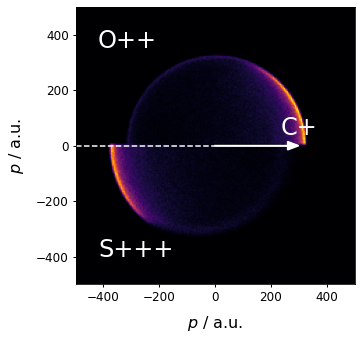

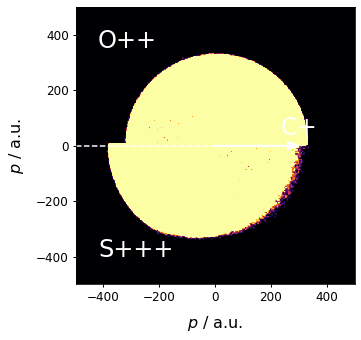

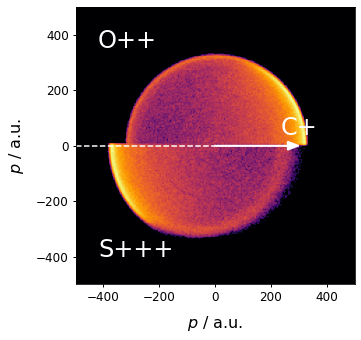

In [23]:
#plot the covariance matrix

import matplotlib.colors as colors



# different linear vmax
fig, ax = plt.subplots(figsize = (5, 5), dpi = 72)

term = cov
image = term
# image = gaussian_filter(term, sigma = 0.5)
ax.imshow(image.T, cmap = 'inferno', vmin = 0,  extent = (-hlf_pxl*bin_size, hlf_pxl*bin_size, -hlf_pxl*bin_size, hlf_pxl*bin_size),
        origin = 'lower', aspect = 'auto')

ax.set_xlabel(r'$p$ / a.u.', fontsize = 16, labelpad = 10)
ax.set_ylabel(r'$p$ / a.u.', fontsize = 16, labelpad = 10)
ax.tick_params(axis = 'x', labelsize = 12)
ax.tick_params(axis = 'y', labelsize = 12)
ax.tick_params('both', length = 3, width = 1)

ax.text(0.80, 0.52, ion_A, transform = ax.transAxes, fontsize = 24, color = 'w', ha  = 'center', va = 'bottom')
ax.text(0.08, 0.92, ion_B, transform = ax.transAxes, fontsize = 24, color = 'w', ha  = 'left', va = 'top')
ax.text(0.08, 0.08, ion_C, transform = ax.transAxes, fontsize = 24, color = 'w', ha  = 'left', va = 'bottom')
ax.arrow(x = 0.5, y = 0.5, dx = 0.3, dy = 0, transform = ax.transAxes, color = 'w', length_includes_head = True, lw = 1.5, head_width = 0.03, head_length = 0.04)
ax.plot((0, 0.5), (0.5, 0.5), ls = 'dashed', lw = 1.5, color = 'w', transform = ax.transAxes)

plt.show()

# different linear vmax
fig, ax = plt.subplots(figsize = (5, 5), dpi = 72)

term = cov
image = term
# image = gaussian_filter(term, sigma = 0.5)
ax.imshow(image.T, cmap = 'inferno', vmin = 0, vmax = np.max(image)/100, extent = (-hlf_pxl*bin_size, hlf_pxl*bin_size, -hlf_pxl*bin_size, hlf_pxl*bin_size),
        origin = 'lower', aspect = 'auto')

ax.set_xlabel(r'$p$ / a.u.', fontsize = 16, labelpad = 10)
ax.set_ylabel(r'$p$ / a.u.', fontsize = 16, labelpad = 10)
ax.tick_params(axis = 'x', labelsize = 12)
ax.tick_params(axis = 'y', labelsize = 12)
ax.tick_params('both', length = 3, width = 1)

ax.text(0.80, 0.52, ion_A, transform = ax.transAxes, fontsize = 24, color = 'w', ha  = 'center', va = 'bottom')
ax.text(0.08, 0.92, ion_B, transform = ax.transAxes, fontsize = 24, color = 'w', ha  = 'left', va = 'top')
ax.text(0.08, 0.08, ion_C, transform = ax.transAxes, fontsize = 24, color = 'w', ha  = 'left', va = 'bottom')
ax.arrow(x = 0.5, y = 0.5, dx = 0.3, dy = 0, transform = ax.transAxes, color = 'w', length_includes_head = True, lw = 1.5, head_width = 0.03, head_length = 0.04)
ax.plot((0, 0.5), (0.5, 0.5), ls = 'dashed', lw = 1.5, color = 'w', transform = ax.transAxes)

plt.show()

# log colour scale
fig, ax = plt.subplots(figsize = (5, 5), dpi = 72)

term = cov
image = term
image[image < np.max(image)/1000] = np.max(image)/1000
ax.imshow(image.T, cmap = 'inferno', norm=colors.LogNorm(vmin=np.max(image)/500, vmax=image.max()), extent = (-hlf_pxl*bin_size, hlf_pxl*bin_size, -hlf_pxl*bin_size, hlf_pxl*bin_size),
        origin = 'lower', aspect = 'auto')

ax.set_xlabel(r'$p$ / a.u.', fontsize = 16, labelpad = 10)
ax.set_ylabel(r'$p$ / a.u.', fontsize = 16, labelpad = 10)
ax.tick_params(axis = 'x', labelsize = 12)
ax.tick_params(axis = 'y', labelsize = 12)
ax.tick_params('both', length = 3, width = 1)

ax.text(0.80, 0.52, ion_A, transform = ax.transAxes, fontsize = 24, color = 'w', ha  = 'center', va = 'bottom')
ax.text(0.08, 0.92, ion_B, transform = ax.transAxes, fontsize = 24, color = 'w', ha  = 'left', va = 'top')
ax.text(0.08, 0.08, ion_C, transform = ax.transAxes, fontsize = 24, color = 'w', ha  = 'left', va = 'bottom')
ax.arrow(x = 0.5, y = 0.5, dx = 0.3, dy = 0, transform = ax.transAxes, color = 'w', length_includes_head = True, lw = 1.5, head_width = 0.03, head_length = 0.04)
ax.plot((0, 0.5), (0.5, 0.5), ls = 'dashed', lw = 1.5, color = 'w', transform = ax.transAxes)

plt.show()